# Задача регрессии по предсказанию цен домов

In [126]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor

import time

In [127]:
# Загрузка данных

train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [128]:
# Посмотрим основную информацию о данных

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [129]:
# Отделим столбец Id от фичей

train_id = train.pop('Id')

test_id = test.pop('Id')

Для начала попробуем получить некий бейслайн, а затем будем подробно анализировать данные и улучшать модель.

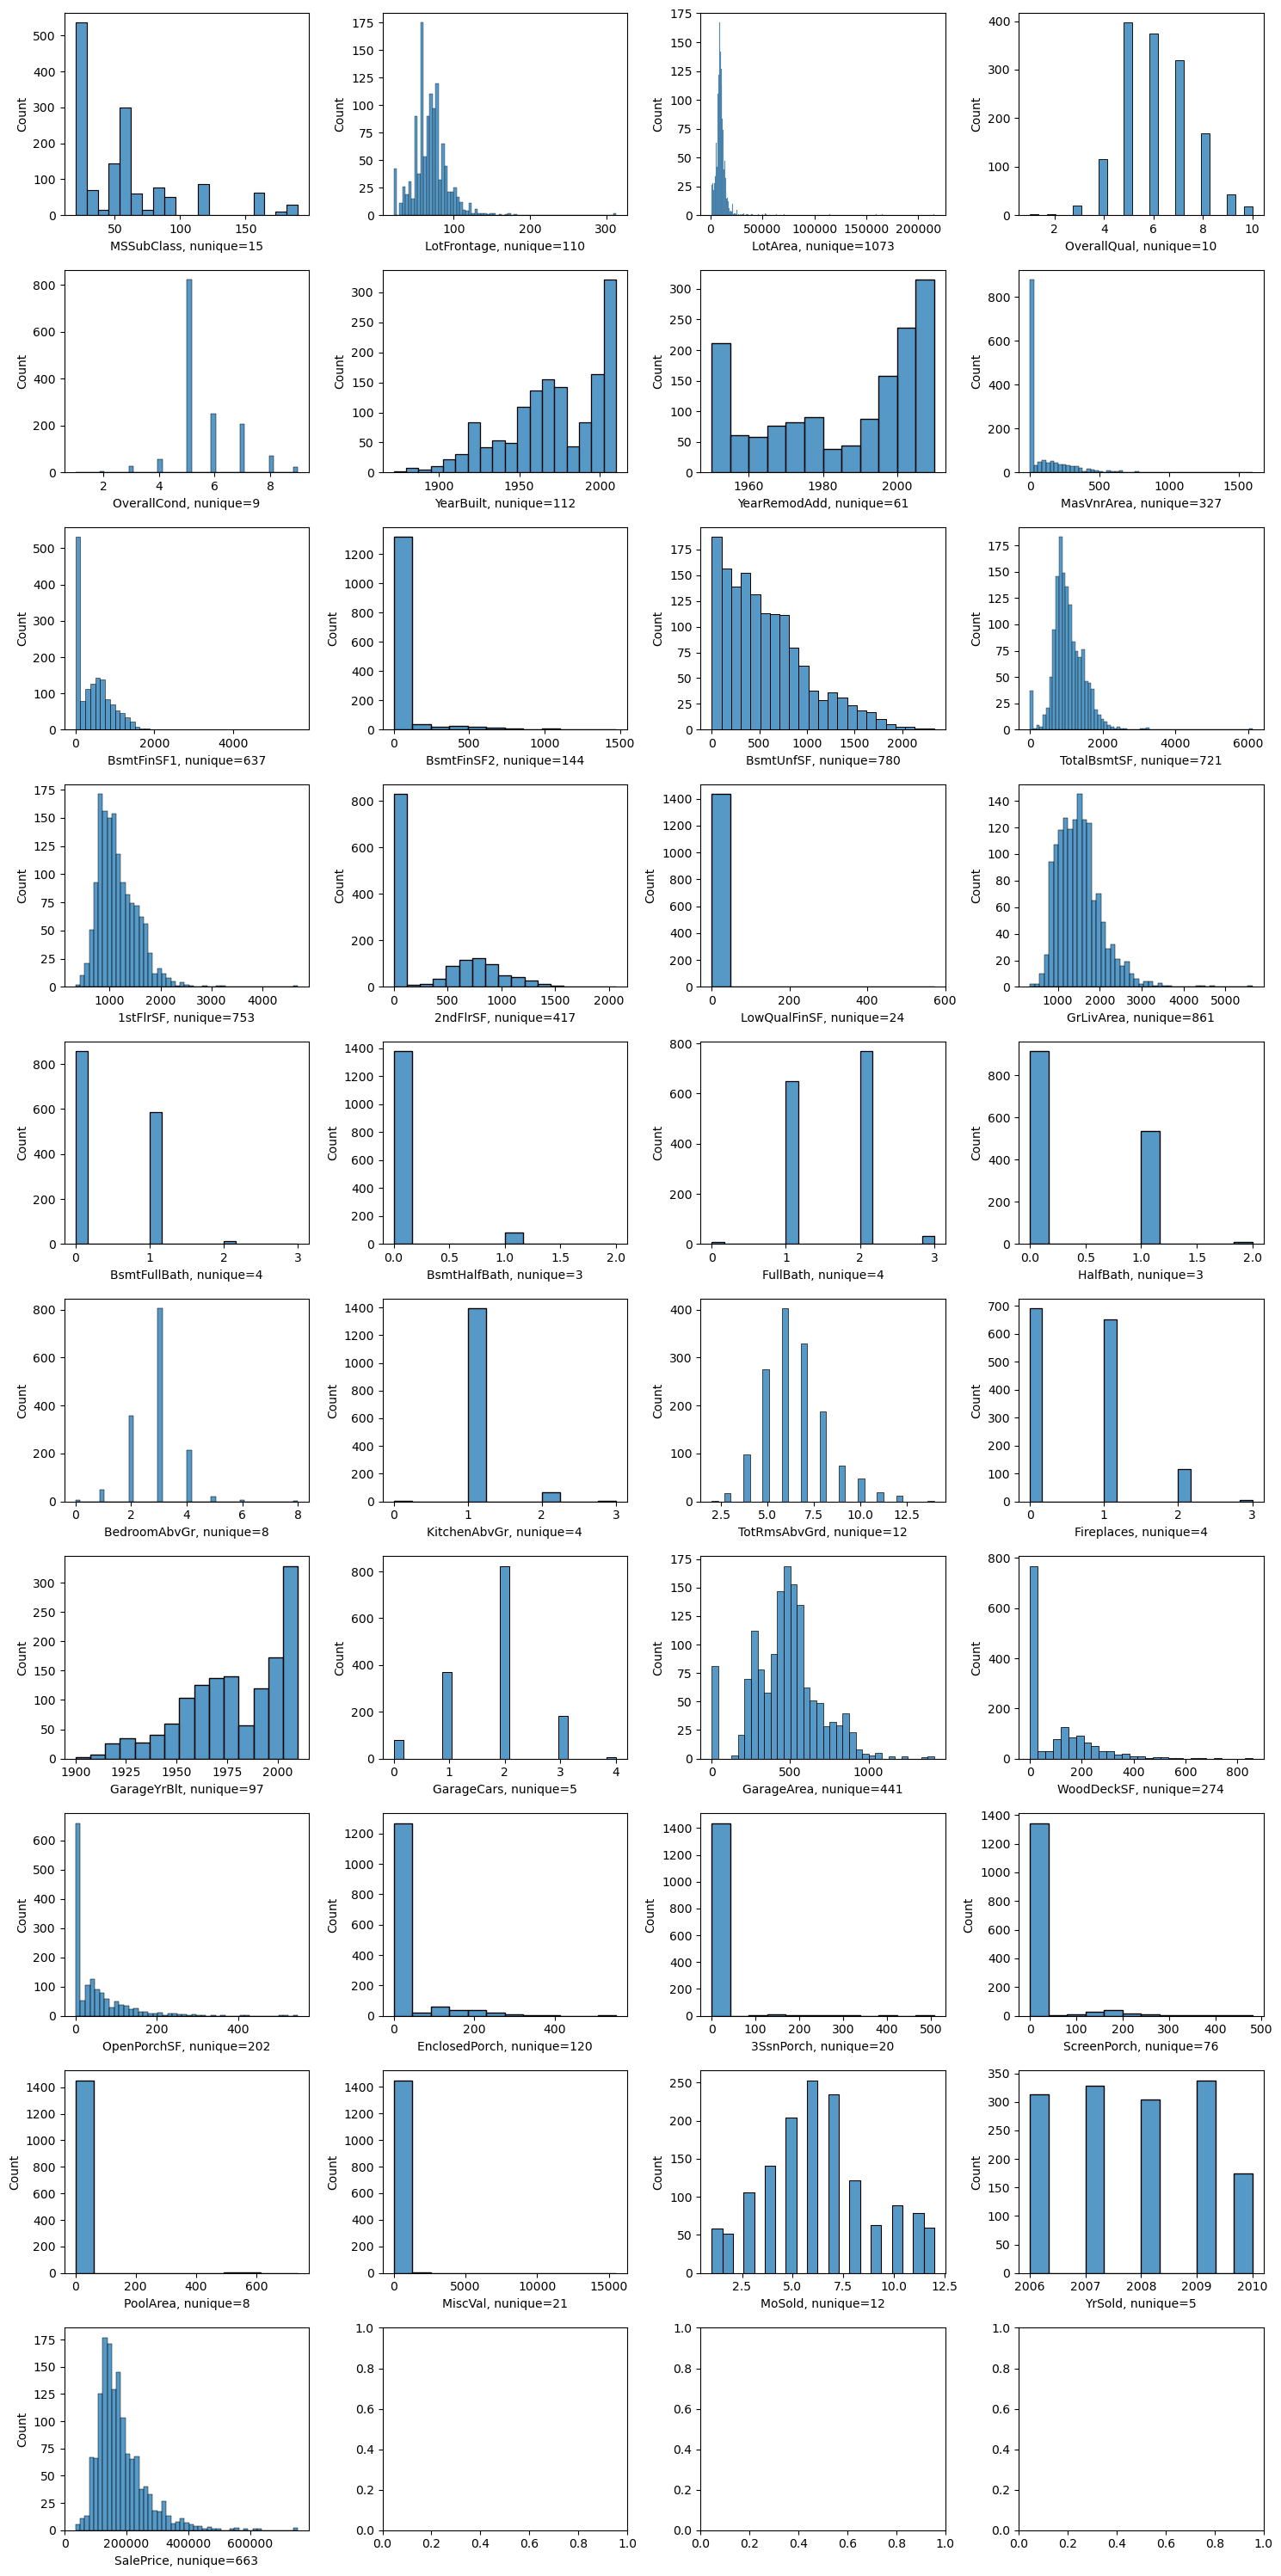

In [130]:
# Посмотрим на распределения признаков, тип данных которых не object

int_float_features = train.select_dtypes(exclude=object).columns

fig, axs = plt.subplots(10, 4, figsize=(15, 30))

for i, feature in enumerate(int_float_features):
    sns.histplot(train[feature], ax=axs[i//4, i%4]).set(xlabel=feature + ', nunique=' + str(train[feature].nunique()))

plt.tight_layout()

In [131]:
# Посмотрим на пропуски в данных

features_with_nan = [feature for feature in train.columns if train[feature].isnull().sum() > 1]
percentage_of_nan = [round(train[feature].isnull().sum() / len(train[feature]) * 100, 2) for feature in features_with_nan]
values = []

for feature in features_with_nan:
    if train[feature].dtype == object:
        values.append(train[feature].unique())
    else:
        values.append([train[feature].min(), train[feature].max()])

train_nan = pd.DataFrame(data={'Feature': features_with_nan, 'PercentageOfNan': percentage_of_nan, 'Values': values})

pd.set_option('max_colwidth', None)
train_nan

,Feature,PercentageOfNan,Values
0,LotFrontage,17.74,"[21.0, 313.0]"
1,Alley,93.77,"[nan, Grvl, Pave]"
2,MasVnrType,0.55,"[BrkFace, None, Stone, BrkCmn, nan]"
3,MasVnrArea,0.55,"[0.0, 1600.0]"
4,BsmtQual,2.53,"[Gd, TA, Ex, nan, Fa]"
5,BsmtCond,2.53,"[TA, Gd, nan, Fa, Po]"
6,BsmtExposure,2.60,"[No, Gd, Mn, Av, nan]"
7,BsmtFinType1,2.53,"[GLQ, ALQ, Unf, Rec, BLQ, nan, LwQ]"
8,BsmtFinType2,2.60,"[Unf, BLQ, nan, ALQ, Rec, LwQ, GLQ]"
9,FireplaceQu,47.26,"[nan, TA, Gd, Fa, Ex, Po]"


In [132]:
# Разделим признаки на категориальные и количественные

cat_features = np.concatenate([train.select_dtypes(include=object).columns, 
                              [feature for feature in train.select_dtypes(exclude=object).columns if train[feature].nunique() < 20 
                               and feature not in ['PoolArea', 'YrSold']]])

num_features = train.drop(np.append(cat_features, 'SalePrice'), axis=1).columns.values

print('num_features: {}, cat_features: {}'.format(len(num_features), len(cat_features)))

num_features: 23, cat_features: 56


Проверим влияние пропусков на целевую переменную. По каждой фиче создадим признак показывающий является ли вхождение пропуском или нет

In [148]:
nan_df = pd.DataFrame(test.isnull())
nan_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,False,False,False,False,False,True,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,...,False,False,True,True,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,...,False,False,True,True,True,False,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,...,False,False,True,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,False,False,False,False,False,True,False,False,False,False,...,False,False,True,True,True,False,False,False,False,False
1455,False,False,False,False,False,True,False,False,False,False,...,False,False,True,True,True,False,False,False,False,False
1456,False,False,False,False,False,True,False,False,False,False,...,False,False,True,True,True,False,False,False,False,False
1457,False,False,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


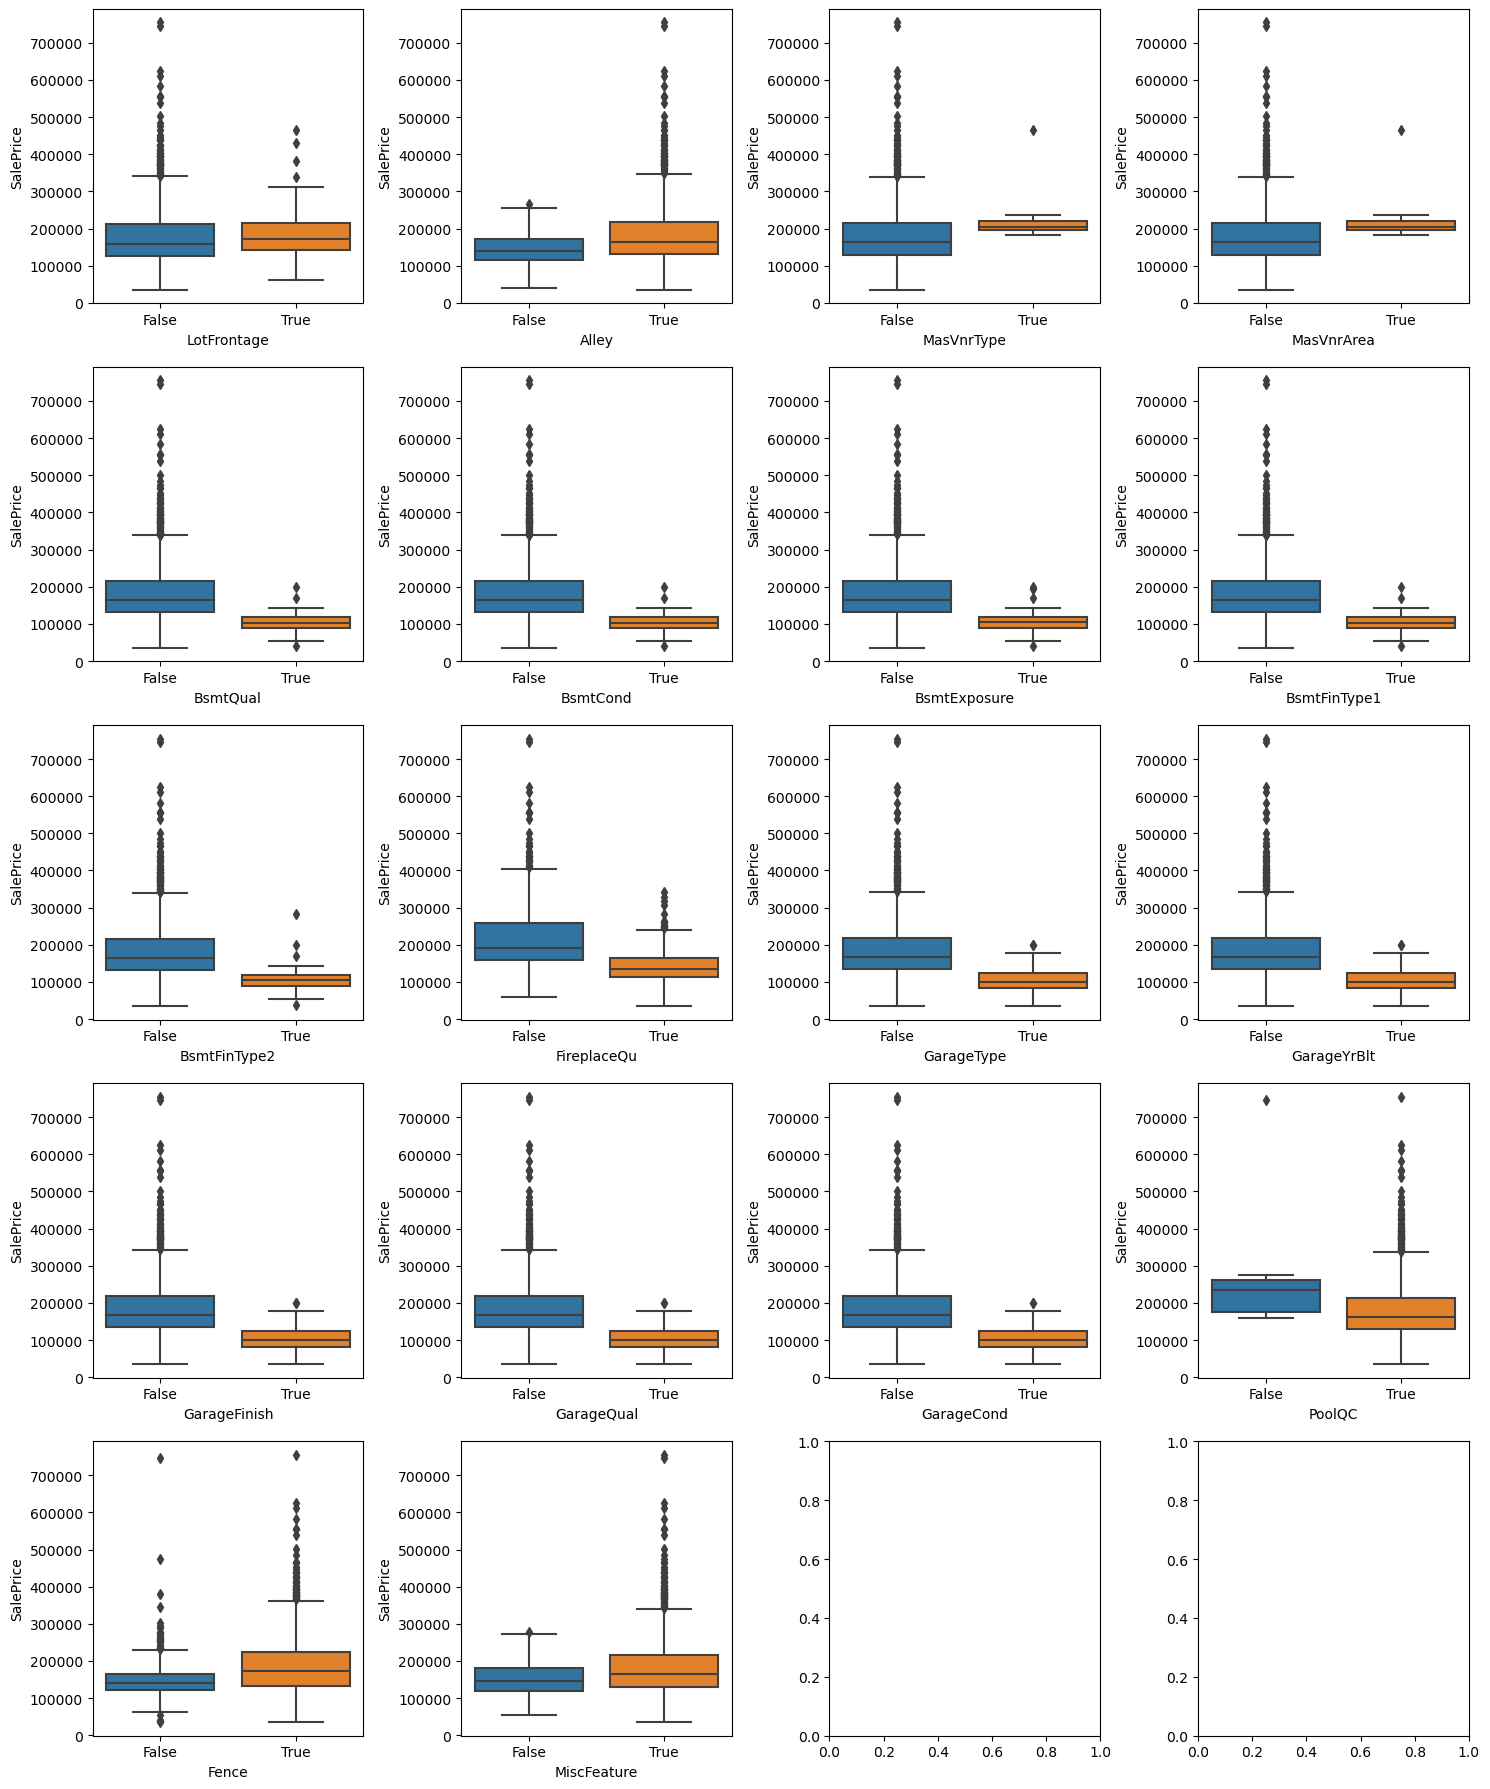

In [146]:
# Зависимость таргета от пропущенных данных

fig, axs = plt.subplots(5, 4, figsize=(15, 18))

for i, feature in enumerate(nan_df.columns):
    sns.boxplot(x=nan_df[feature], y=train['SalePrice'], ax=axs[i//4, i%4])
    
fig.tight_layout()

In [91]:
# Заполним пропуски

train[cat_features] = train[cat_features].fillna('No_info')
train[num_features] = train[num_features].fillna(train[num_features].median())

test[cat_features] = test[cat_features].fillna('No_info')
test[num_features] = test[num_features].fillna(test[num_features].median())

In [92]:
# Закодируем категориальные переменные

dummy_train = pd.get_dummies(train.drop('SalePrice', axis=1))

dummy_train.shape

(1460, 304)

In [93]:
# Обучим случайный лес и градиентный бустинг

X_train, X_test, y_train, y_test = train_test_split(dummy_train, train['SalePrice'], random_state=1)

gb = GradientBoostingRegressor(random_state=1)

gb.fit(X_train, y_train)

GradientBoostingRegressor(random_state=1)

In [94]:
print('R2 GB = ', gb.score(X_test, y_test))

print('RMSE GB = ', mean_squared_error(y_test, gb.predict(X_test), squared=False))

R2 GB =  0.9178075988240353
RMSE GB =  23489.91979790207


Теперь попытаемся улучшить этот результат

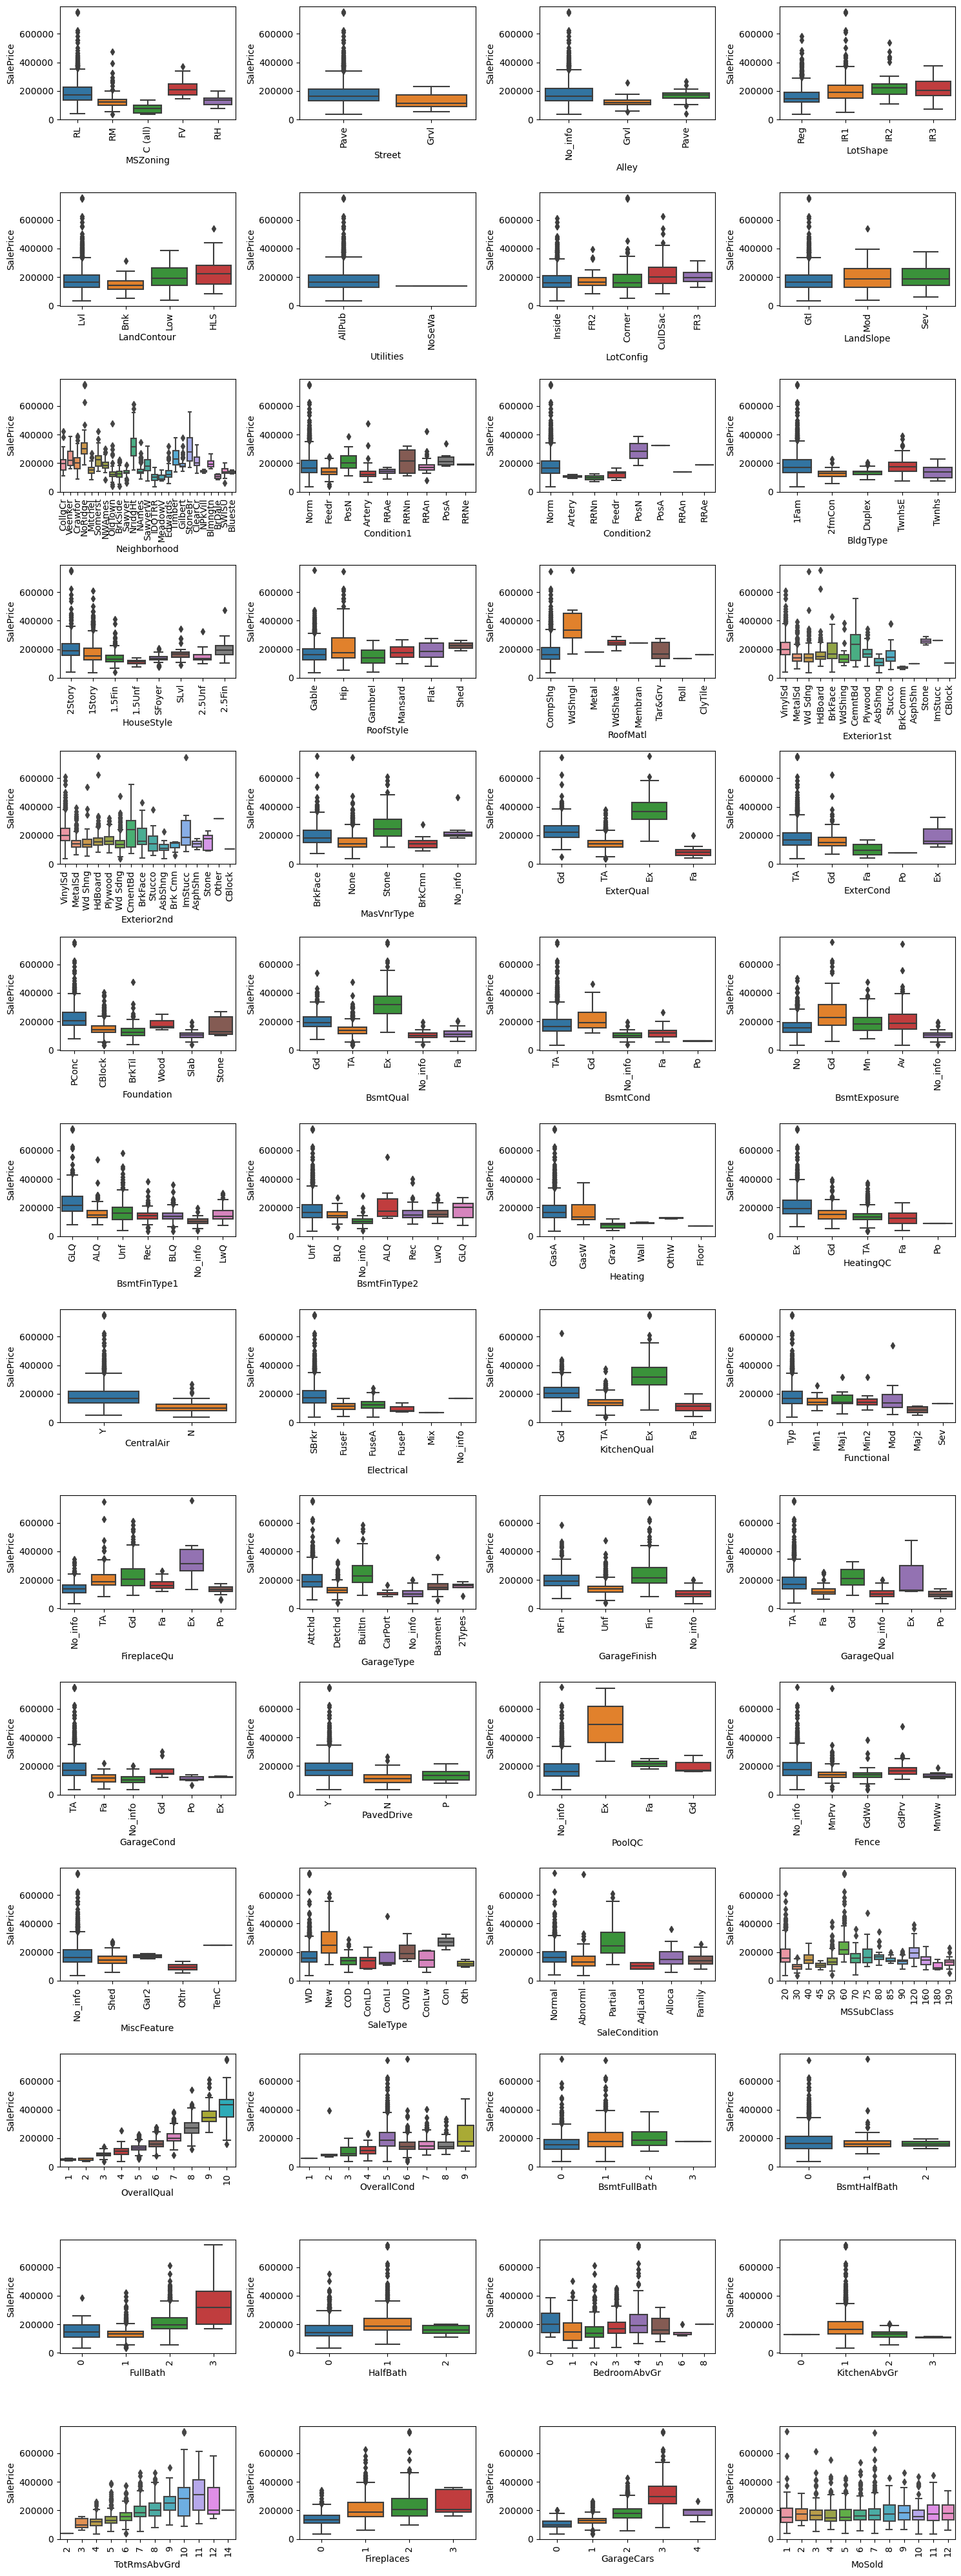

In [106]:
# Зависимость таргета от категориальных переменных

fig, axs = plt.subplots(14, 4, figsize=(15, 40))

for i, feature in enumerate(cat_features):
    sns.boxplot(x=train[feature], y=train['SalePrice'], ax=axs[i//4, i%4])
    plt.setp(axs[i//4, i%4].get_xticklabels(), rotation=90)
    
fig.tight_layout()

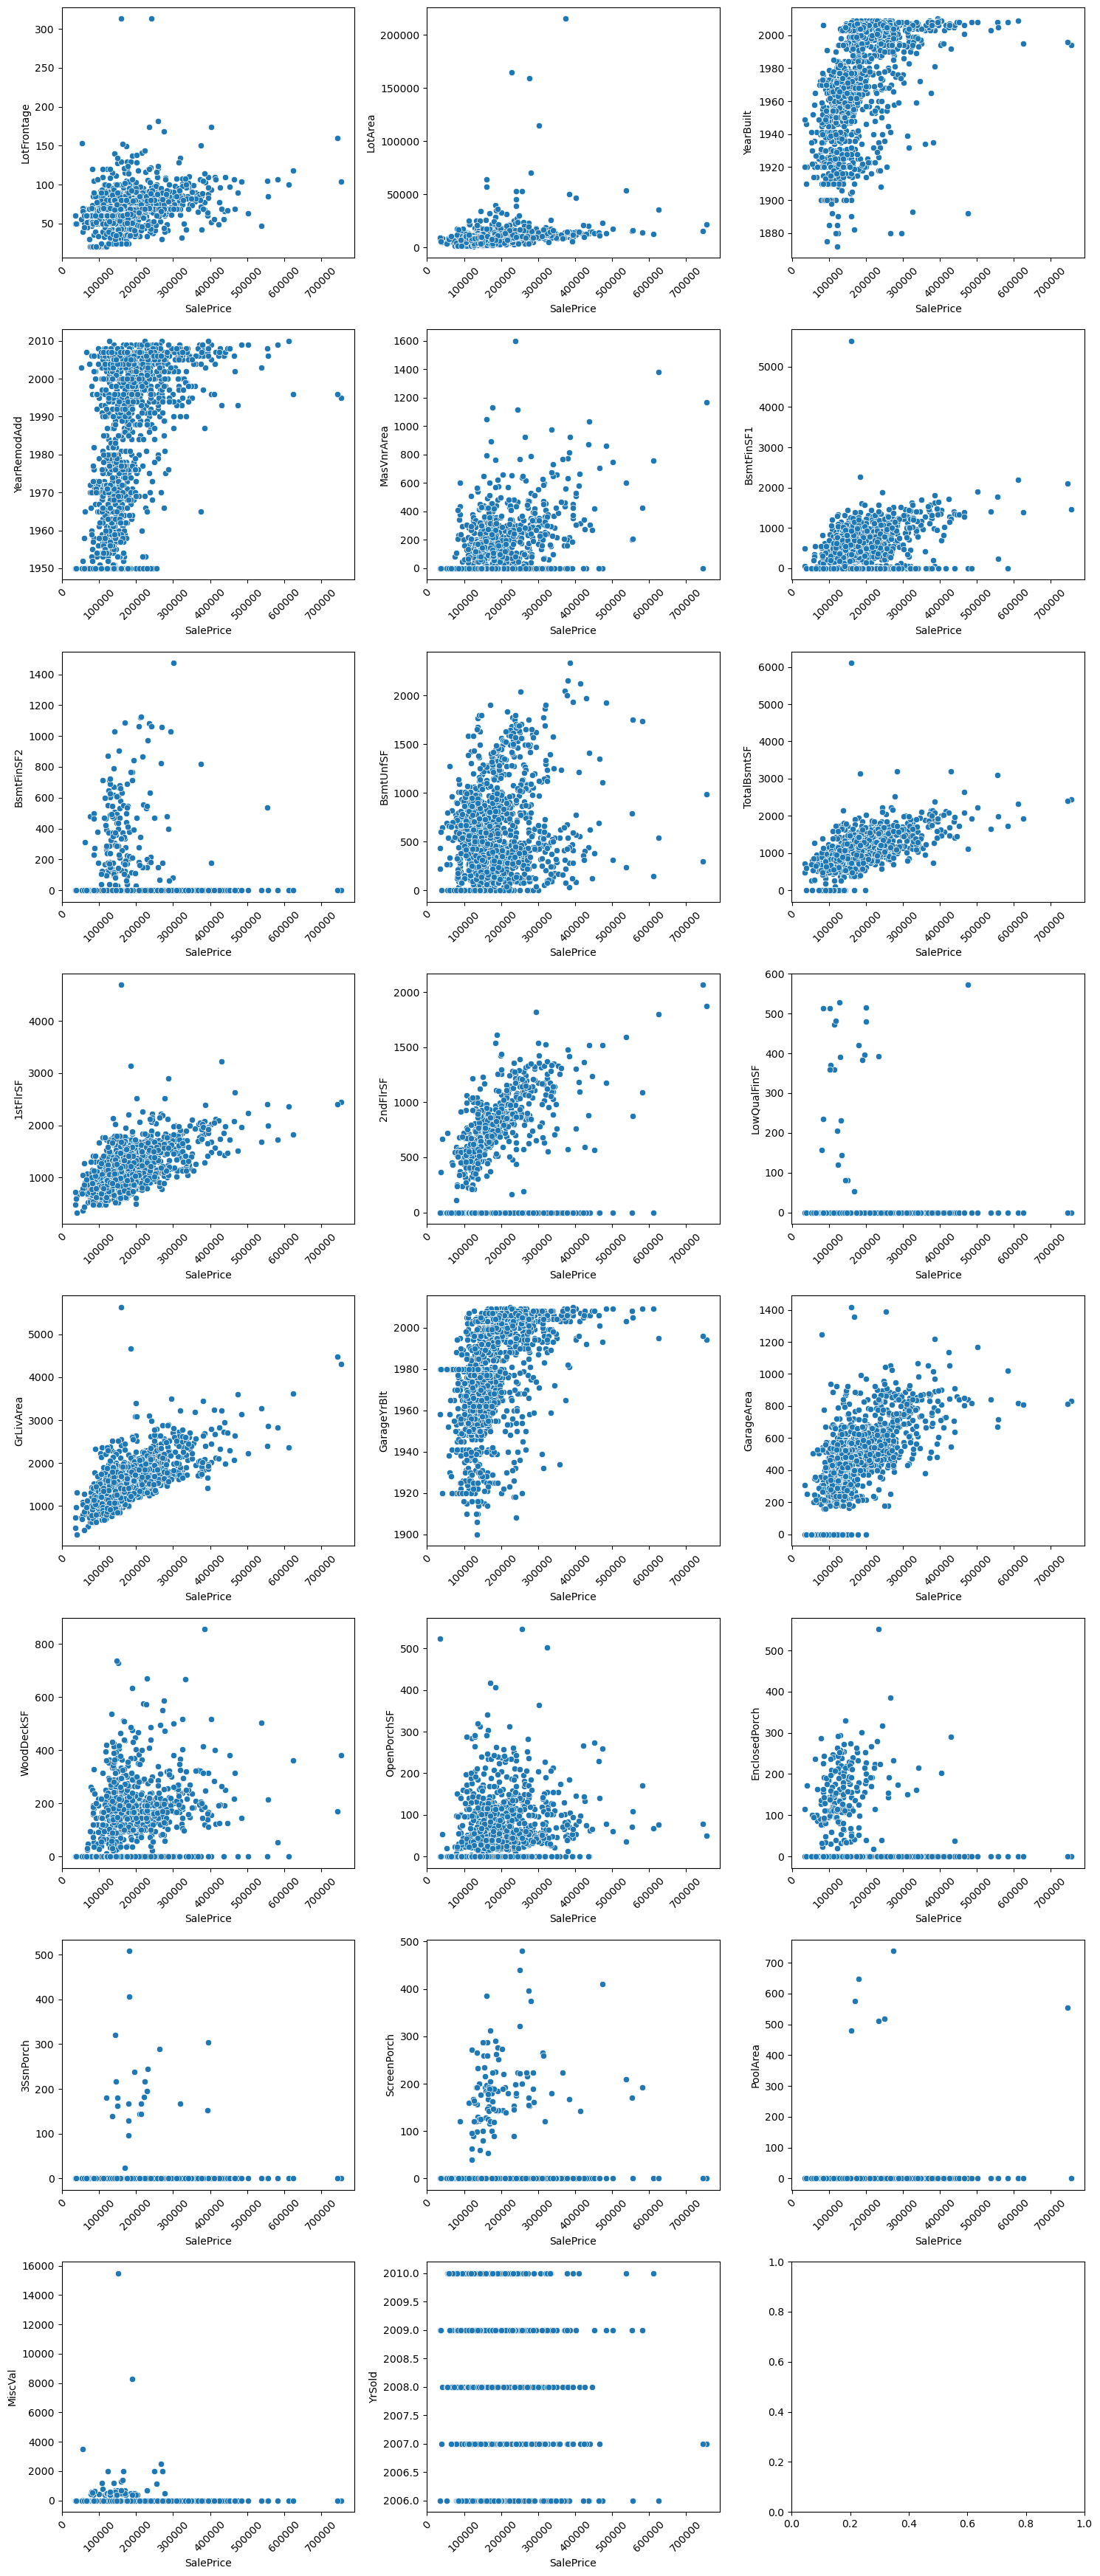

In [96]:
# Зависимость таргета от количественных признаков

fig, axis = plt.subplots(8, 3, figsize=(15, 35))

for i, feature in enumerate(num_features):
    sns.scatterplot(x='SalePrice', y=feature, data=train, ax=axis[i//3, i%3])
    plt.setp(axis[i//3, i%3].get_xticklabels(), rotation=45)

fig.tight_layout()

Теперь избавимся от выбросов

In [97]:
train_preproc = train.copy()

for feature in num_features:
    iqr = 1.5 * (np.percentile(train_preproc[feature], 75) - np.percentile(train_preproc[feature], 25))
    train_preproc = train_preproc.drop(train_preproc[train_preproc[feature] > (np.percentile(train_preproc[feature], 75) + iqr)].index)
    train_preproc = train_preproc.drop(train_preproc[train_preproc[feature] < (np.percentile(train_preproc[feature], 25) - iqr)].index)

In [98]:
# Закодируем категориальные переменные

dummy_train_preproc = pd.get_dummies(train_preproc.drop('SalePrice', axis=1))

print(train.shape)
print(train_preproc.shape)
print(dummy_train_preproc.shape)


dummy_test_preproc = pd.get_dummies(test)

print(test.shape)
print(dummy_test_preproc.shape)

(1460, 80)
(660, 80)
(660, 254)
(1459, 79)
(1459, 305)


In [99]:
intersect_features = np.intersect1d(dummy_test_preproc.columns, dummy_train_preproc.columns)

intersect_features.shape

(248,)

In [100]:
# Обучим случайный лес и градиентный бустинг

X_train, X_test, y_train, y_test = train_test_split(dummy_train_preproc[intersect_features], train_preproc['SalePrice'], random_state=1)

gb.fit(X_train, y_train)

GradientBoostingRegressor(random_state=1)

In [101]:
print('R2 GB = ', gb.score(X_test, y_test))

print('RMSE GB = ', mean_squared_error(y_test, gb.predict(X_test), squared=False))

R2 GB =  0.8897564624012739
RMSE GB =  18540.717477647566


R2 ухудшился, но RMSE стал лучше, интересно. Чтож тогда попробуем хотябы воспользоваться RandomizedSearch. Затем можно построить несколько кривых валидации и обучения и оценить результат. Посмотреть есть ли информация в nan. Далее подберем правильнцю метрику или оценим сразу по нескольким метрикам и обсудим каждую. и выгрузка в SQL и сравнение с петом женька далее шлифовка и обсуждение с женьком. хорошо бы на этих выходных

[Text(0, 0, 'OverallQual'),
 Text(1, 0, 'YearBuilt'),
 Text(2, 0, 'GrLivArea'),
 Text(3, 0, 'GarageArea'),
 Text(4, 0, 'BsmtFinSF1'),
 Text(5, 0, 'TotalBsmtSF'),
 Text(6, 0, 'BsmtQual_Ex'),
 Text(7, 0, 'FullBath'),
 Text(8, 0, '1stFlrSF'),
 Text(9, 0, 'GarageYrBlt'),
 Text(10, 0, 'MasVnrArea'),
 Text(11, 0, 'OverallCond'),
 Text(12, 0, 'Neighborhood_StoneBr'),
 Text(13, 0, 'LotArea'),
 Text(14, 0, 'LotFrontage'),
 Text(15, 0, 'YearRemodAdd'),
 Text(16, 0, 'BsmtFinType1_GLQ'),
 Text(17, 0, 'GarageFinish_Unf'),
 Text(18, 0, 'GarageType_Attchd'),
 Text(19, 0, '2ndFlrSF')]

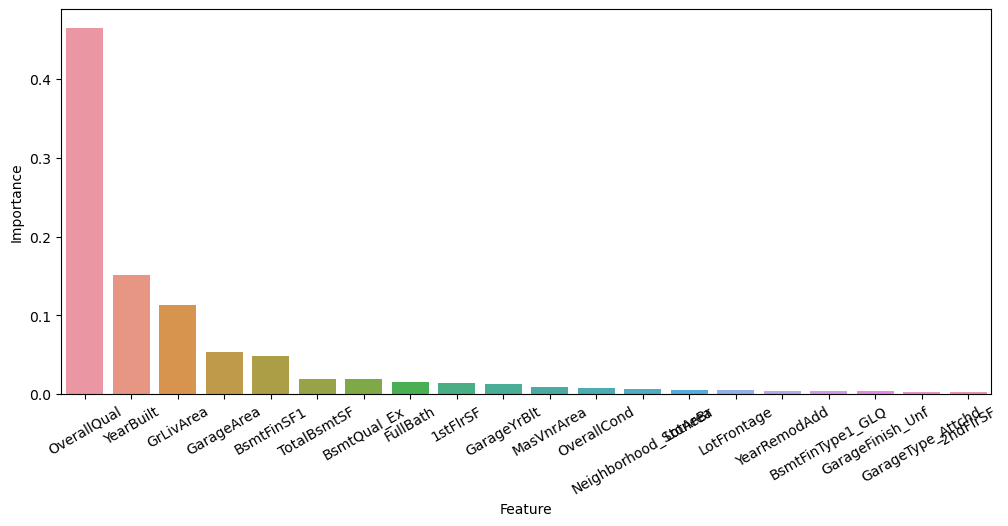

In [124]:
# Отберем важные фичи и сделаем кроссвалидацию на них

importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': gb.feature_importances_}).sort_values(by='Importance', ascending=False)

important_features = importance_df['Feature'].head(20)

plt.figure(figsize = (12, 5))
ax = sns.barplot(x=importance_df.head(20)['Feature'], y=importance_df.head(20)['Importance'])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

In [103]:

params = {'n_estimators': [800, 900, 1000, 1100], 
          'max_depth': [1, 2, 3],
          'min_samples_split': [8, 10, 12, 14],
          'min_samples_leaf': [6, 8, 10]}

start = time.time()
search = RandomizedSearchCV(gb, params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5, random_state=1)
end = time.time()

search.fit(X_train, y_train)
print(search.best_params_)
print(end - start)

{'n_estimators': 900, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_depth': 1}
40.02656388282776


In [104]:
print('R2 GB = ', search.best_estimator_.score(X_test, y_test))

print('RMSE GB = ', mean_squared_error(y_test, search.best_estimator_.predict(X_test), squared=False))

R2 GB =  0.911942748532423
RMSE GB =  16570.382313908067


In [105]:
fin_pred = search.best_estimator_.predict(dummy_test_preproc[intersect_features])

fin_pred_df = pd.DataFrame({'Id': test_id, 'SalePrice': fin_pred})

fin_pred_df.to_csv('hous.csv', index=False)

fin_pred_df

,Id,SalePrice
0,1461,132575.806747
1,1462,170184.542724
2,1463,190620.199365
3,1464,197201.362469
4,1465,215127.126977
...,...,...
1454,2915,88137.034663
1455,2916,83862.994073
1456,2917,170685.832438
1457,2918,132643.159472


Итог: 0,15075 на финальной тестовой выборке